In [1]:
using Distributions
using PyPlot

In [2]:
# 多次元ガウス分布からのサンプリング
mu1 = Float64[2, 5]
mu2 = Float64[-3, 2]
sig = (fill(1.0, (2, 2)) + Diagonal([1, 1]))*0.3
x1 = rand(MvNormal(mu1, sig), 50)
x2 = rand(MvNormal(mu2, sig), 50)

mu3 = Float64[1, -5]
sig2 = Float64[1.5 1.0; 1.0 1.5]
x3 = rand(MvNormal(mu3, sig2), 100)

2×100 Array{Float64,2}:
 -1.8715   -0.109351   1.03595  -1.42085  …   0.287493   3.5841    0.0266403
 -7.02744  -3.46814   -6.11529  -7.53533     -4.91881   -4.37975  -6.66908  

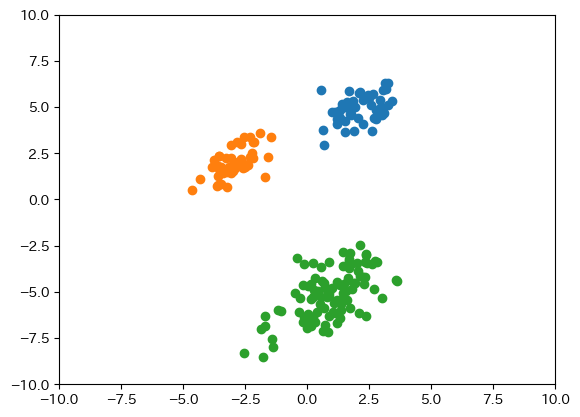

(-10, 10)

In [3]:
scatter(x1[1,:], x1[2,:])
scatter(x2[1,:], x2[2,:])
scatter(x3[1,:], x3[2,:])
xlim(-10, 10)
ylim(-10, 10)

## k-means
k-meansは、アルゴリズム的に局所解に陥るが、初期値によってどの程度影響があるのかを調べる。

In [4]:
function cal_err(X, Z, mu)
    N = size(X, 2)
    err = 0.0
    for i in 1:N
        z_i = Z[i]
        err += norm(X[:,i] - mu[:,z_i])
    end
    return err
end

cal_err (generic function with 1 method)

In [77]:
# クラスタ数と初期値
K = 3
mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
#mu = hcat(mu3.-0.5, mu3, mu3.+0.5)

X = hcat(hcat(x1, x2), x3)
N = size(X, 2)
D = ndims(X)

Z = zeros(Int64, N)

err = 10000.0
count = 0
while err > 420
    nk = zeros(K)
    for i in 1:N
        distances = [norm(mu[:, k] - X[:, i]) for k in 1:K]
        z_i = indmin(distances)
        Z[i] = z_i
        nk[z_i] += 1
    end
    for k in 1:K
        mu[:, k] = [sum(X[:, Z.==k][d,:])/nk[k] for d in 1:D]
    end
    err = cal_err(X, Z, mu)
    println(err)
end

LoadError: [91mUndefVarError: cal_err not defined[39m

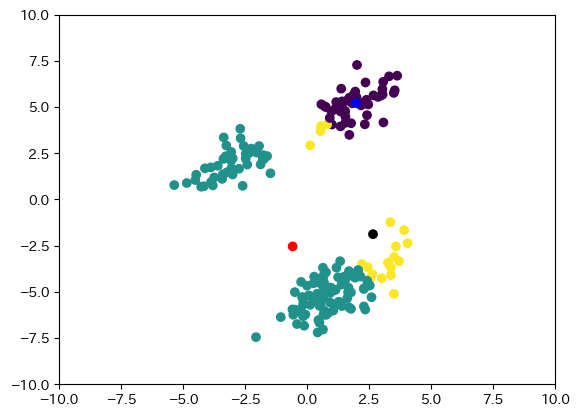

(-10, 10)

In [78]:
PyPlot.clf()
#X = hcat(hcat(x1, x2), x3)
#mu = hcat(mu1, mu2)
scatter(X[1,:], X[2,:], c=Z)
scatter(mu[1, :], mu[2, :], c=["blue", "red", "black"])
xlim(-10, 10)
ylim(-10, 10)

## 混合ガウス分布（分散固定ver）
ベイズ的に求めると、初期値の問題を解消できるのか検証

In [4]:
# 潜在変数をサンプリングするカテゴリカル分布のパラメータを求める関数
function cal_catparams(x, mu, K)
    D = size(mu,1)
    I = eye(D)
    p = zeros(K)
    for k in 1:K
        p[k] = pdf(MvNormal(mu[:,k], I), x)
    end
    return p./sum(p,1)
end

cal_catparams (generic function with 1 method)

In [5]:
# クラスタセンタをサンプリングするガウス分布のパラメータを求める関数
function cal_gaussparams(X, Z, k, nk, mu_0, sigma_0)
    N = size(X, 2)
    D = size(X,1)
    x_hat = zeros(D)
    for i in 1:N
        if(Z[i] == k)
            x_hat += X[:, i]
        end
    end
    return (x_hat + mu_0.*sigma_0^2)./(nk[k] + sigma_0^2), eye(D)./(nk[k] + sigma_0^2)
end

cal_gaussparams (generic function with 1 method)

In [46]:
# クラスタ数と初期値
K = 3
#mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
mu = hcat(mu3.-0.5, mu3, mu3.+0.5)
#mu = rand(MvNormal([0.0, 0.0], eye(2)), 3)
S = 1

X = hcat(hcat(x1, x2), x3)
N = size(X, 2)
D = ndims(X)
I = eye(D)

# ハイパーパラメータ
pi_0 = [1/K for _ in 1:K]
mu_0 = zeros(size(X, 1))
#mu_0 = mu3
sigma_0 = 1.0

Z = zeros(Int64, N)

for s in 1:S
    nk = zeros(K)
    log_likelihood = 0.0 
    
    for i in 1:N
        p = cal_catparams(X[:,i], mu, K)
        z_i = rand(Categorical(p), 1)[1]
        Z[i] = z_i
        nk[z_i] += 1
        log_likelihood += (pdf(MvNormal(mu[:,z_i], I), X[:, i]) + pdf(Categorical(pi_0), z_i))
    end
    for k in 1:K
        mu_hat, sig_hat = cal_gaussparams(X, Z, k, nk, mu_0, sigma_0)
        mu_k = rand(MvNormal(mu_hat, sig_hat), 1)
        mu[:,k] = mu_k
        log_likelihood += pdf(MvNormal(mu_0, (sigma_0^2).*I), mu_k)
    end
    println("log likelihood: ", log_likelihood)
end
        

log likelihood: [74.2672]


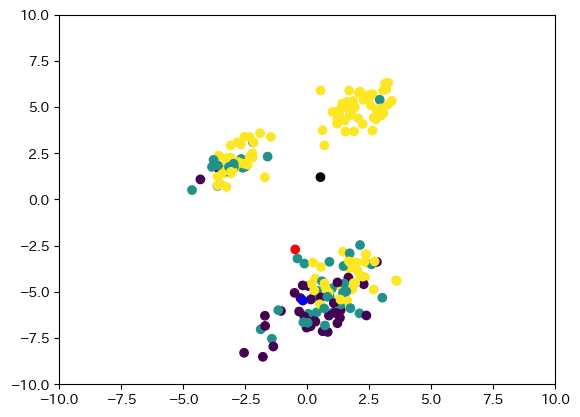

(-10, 10)

In [47]:
PyPlot.clf()
#X = hcat(hcat(x1, x2), x3)
#mu = hcat(mu1, mu2)
#mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
scatter(X[1,:], X[2,:], c=Z)
scatter(mu[1, :], mu[2, :], c=["blue", "red", "black"])
xlim(-10, 10)
ylim(-10, 10)

## k-meansと分散固定ガウス分布の比較

### 上に初期点を３つ並べ場合
パラメータを確率的に推定しているガウス分布でのクラスタリングの方が局所解に陥らないと思っていたが、結果は逆であった。  
~~ガウス分布の方が、上手くクラスタリングできないという結果になった。~~  
追記：何回か実行すると、上手く分類できる場合もあった。  
分散が固定であるため、クラスタセンタからある程度離れている点は殆どランダムになってしまうため、その点の影響でクラスタセンタが引っ張られてしまったと考えることができる。  
これは、分散も推定するようにすることで改善できるのでは無いかと考えられる。

### 下に初期点を３つ並べた場合
これは、どちらのアルゴリズムでも上手く分類できなかった。  

### 全体
どちらのアルゴリズムも初期点をランダムにすれば上手く学習できたので、何回か初期点を変えて値（k-meansではerr, 混合ガウスでは尤度）を見てどれにするかを判断するのが良い。  



(122,)